# Time Series Models

In [ ]:
!pip install pmdarima

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [4]:
data_clen = 'https://raw.githubusercontent.com/Ly-Ax/RetailML/main/data/clean/coffee_shop_clean.csv'
num_days = 30

## Split Data

In [5]:
df = pd.read_csv(data_clen)

df = df[['trn_date', 'total_bill']]
df.columns = ['date','sales']

df.date = pd.to_datetime(df.date)
df = df.groupby('date')['sales'].sum().reset_index()

df.iloc[[0,-1]]

,date,sales
0,2023-01-01,2508.20
180,2023-06-30,5481.32


In [6]:
# Train & Test Datasets
df_train = df.iloc[:-num_days]
df_test = df.iloc[-num_days:]

print(f'Train range: {str(df_train.date.min())[0:10]} to {str(df_train.date.max())[0:10]}')
print(f'Test range:  {str(df_test.date.min())[0:10]} to {str(df_test.date.max())[0:10]}')

Train range: 2023-01-01 to 2023-05-31
Test range:  2023-06-01 to 2023-06-30


In [7]:
# ARIMA Datasets
arima_train = df_train.copy()
arima_test = df_test.copy()

arima_train.set_index(arima_train.date, inplace=True)
arima_train.drop(columns=['date'], inplace=True)

arima_test.set_index(arima_test.date, inplace=True)
arima_test.drop(columns=['date'], inplace=True)

arima_train.head(2)

,sales
date,
2023-01-01,2508.20
2023-01-02,2403.35


In [9]:
# Prophet Datasets
prophet_train = df_train.copy()
prophet_test = df_test.copy()

prophet_train.columns = ['ds','y']
prophet_test.columns = ['ds','y']

prophet_train.head(2)

,ds,y
0,2023-01-01,2508.20
1,2023-01-02,2403.35


## Analysis

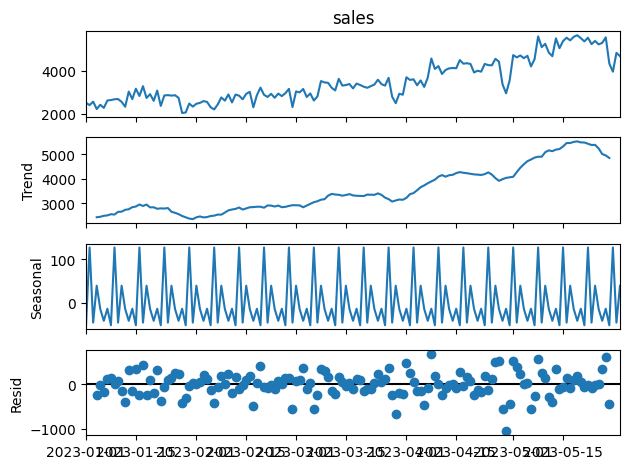

In [10]:
sd_sales = seasonal_decompose(arima_train.sales, model='add')
sd_sales.plot();

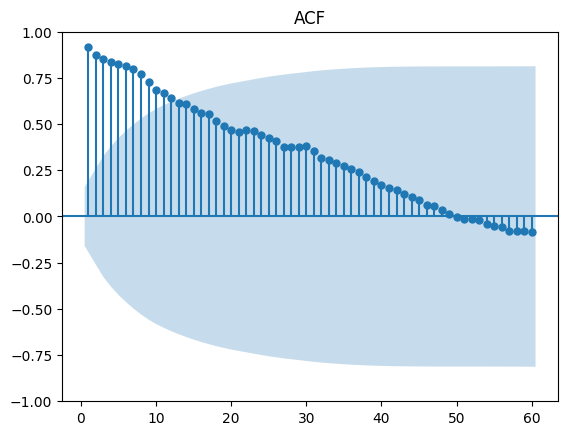

In [11]:
plot_acf(arima_train.sales, lags=60, zero=False)
plt.title('ACF')
plt.show()

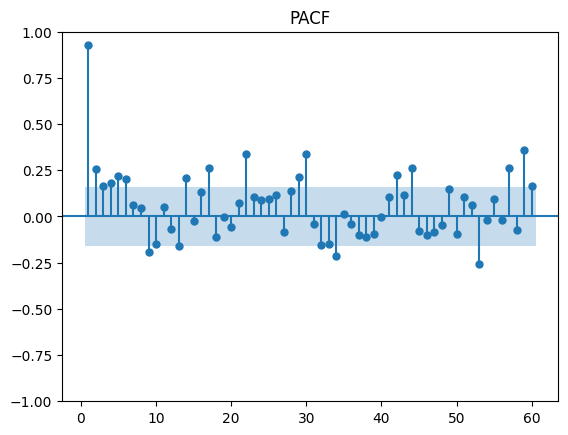

In [12]:
plot_pacf(arima_train.sales, lags=60, zero=False, method='ols')
plt.title('PACF')
plt.show()

## ARIMA

In [13]:
model_arima = ARIMA(arima_train, order=(30, 2, 2)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

In [14]:
arima_pred = model_arima.forecast(steps=num_days)

arima_rmse = round(np.sqrt(mean_squared_error(arima_test, arima_pred)),2)
print('ARIMA RMSE:', arima_rmse)

ARIMA RMSE: 322.18


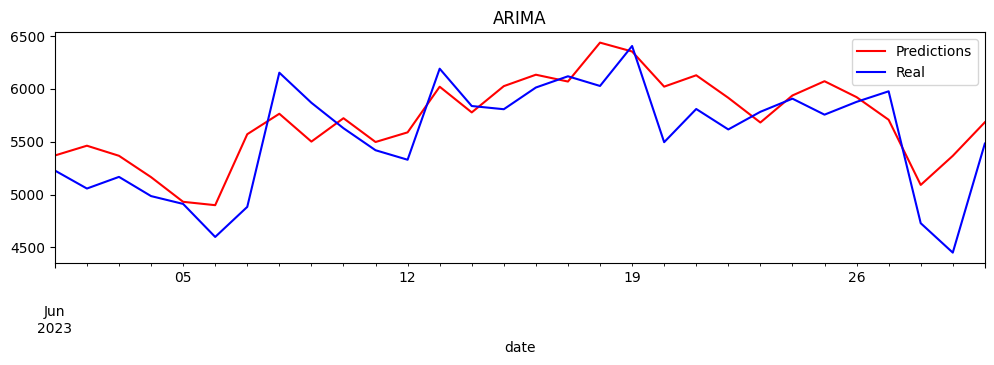

In [15]:
arima_pred.plot(figsize=(12,3), color='red')
arima_test.sales.plot(color='blue')

plt.title('ARIMA')
plt.legend(['Predictions','Real'])
plt.show()

## Auto ARIMA

In [16]:
model_auto = auto_arima(arima_train, start_p=1, start_q=1, max_p=30, max_q=30,
                        max_order=None, start_P=1, start_Q=0, m=10, d=0, D=1)
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  151
Model:             SARIMAX(2, 0, 1)x(2, 1, [1, 2], 10)   Log Likelihood               -1025.018
Date:                                 Tue, 30 Apr 2024   AIC                           2068.035
Time:                                         02:19:39   BIC                           2094.574
Sample:                                     01-01-2023   HQIC                          2078.820
                                          - 05-31-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     47.2294     30.863      1.530      0.126     -13.261     107.720
ar.L1          0.8837      0.192      4.606      0.000       0.508       1.260
ar.L2          0.0131      0.142      0.092      0.926      -0.265       0.291
ma.L1         -0.5263      0.192     -2.743      0.006      -0.902      -0.150
ar.S.L10      -0.6866      0.178     -3.858      0.000      -1.035      -0.338
ar.S.L20      -0.4363      0.075     -5.855      0.000      -0.582      -0.290
ma.S.L10      -0.4432      0.202     -2.198      0.028      -0.838      -0.048
ma.S.L20      -0.3701      0.229     -1.615      0.106      -0.819       0.079
sigma2      9.811e+04   1.28e+04      7.645      0.000     7.3e+04    1.23e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.58   Prob(JB):                         0.73
Heteroskedasticity (H):               1.67   Skew:                            -0.01
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
auto_pred = model_auto.predict(n_periods=num_days)

auto_rmse = round(np.sqrt(mean_squared_error(arima_test, auto_pred)),2)
print('Auto ARIMA RMSE:', auto_rmse)

Auto ARIMA RMSE: 461.74


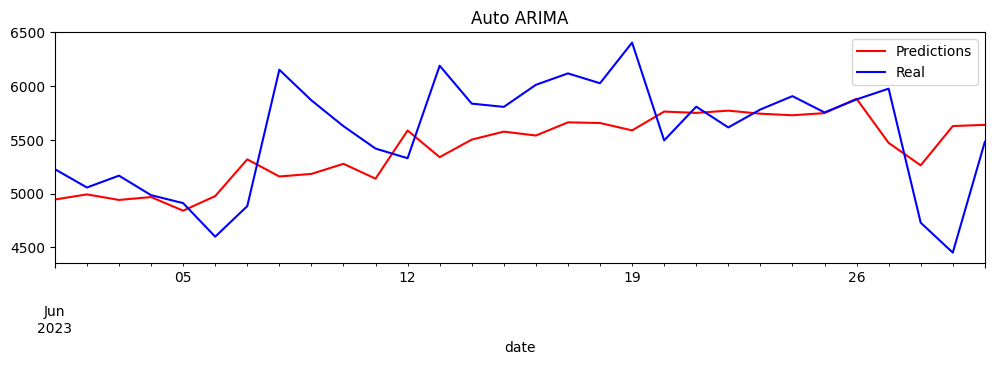

In [18]:
auto_pred.plot(figsize=(12,3), color='red')
arima_test.sales.plot(color='blue')

plt.title('Auto ARIMA')
plt.legend(['Predictions','Real'])
plt.show()

## SARIMA

In [19]:
model_sarima = SARIMAX(arima_train, order=(2,1,1), seasonal_order=(1,1,1,12)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
sarima_pred = model_sarima.predict(start=df_test.date.min(), end=df_test.date.max())

sarima_rmse = round(np.sqrt(mean_squared_error(arima_test, sarima_pred)),2)
print('SARIMA RMSE:', sarima_rmse)

SARIMA RMSE: 613.57


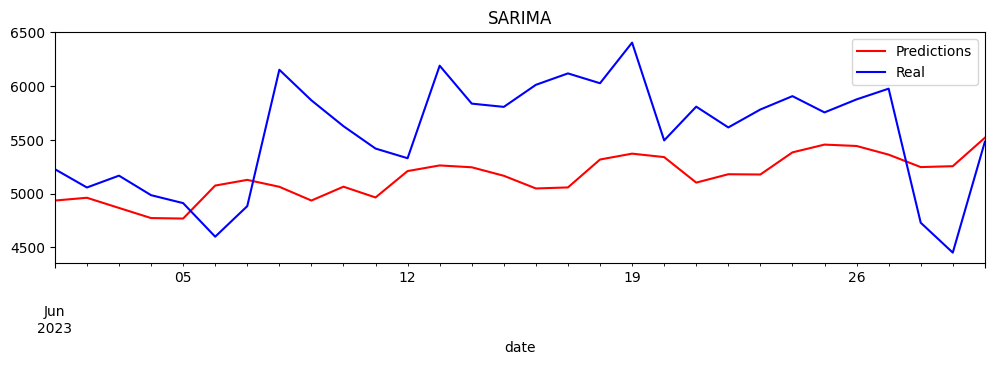

In [21]:
sarima_pred.plot(figsize=(12,3), color='red')
arima_test.sales.plot(color='blue')

plt.title('SARIMA')
plt.legend(['Predictions','Real'])
plt.show()

## Prophet

### Tuning

In [22]:
matrix = {
    'yearly_seasonality': ["auto", False, True],
    'weekly_seasonality': ["auto", False, True],
    'seasonality_mode': ['multiplicative', 'additive'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1, 10],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10],
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'changepoint_range': [0.8, 0.9, 0.95]
}

In [23]:
params = [dict(zip(matrix.keys(), val)) for val in itertools.product(*matrix.values())]
rmses = []

In [ ]:
for param in params:
    model = Prophet(**param).fit(prophet_train)
    future = model.make_future_dataframe(num_days, freq='D')
    forecast = model.predict(future)
    df_pred = pd.DataFrame(forecast.yhat[-num_days:].values, index=forecast[-num_days:].ds.values)
    rmses.append(np.sqrt(mean_squared_error(prophet_test.y, df_pred.values)))

In [25]:
tuning = pd.DataFrame(params)
tuning["rmse"] = rmses
tuning.sort_values("rmse", inplace=True)
tuning.head(3)

,yearly_seasonality,weekly_seasonality,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,changepoint_range,rmse
50,auto,auto,multiplicative,0.01,0.01,0.01,0.95,535.217833
2450,False,True,multiplicative,0.01,0.01,0.01,0.95,535.217833
1499,False,auto,multiplicative,0.01,0.01,10.00,0.95,535.217833


### Trainig

In [ ]:
model_prophet = Prophet(yearly_seasonality='auto',
                        weekly_seasonality='auto',
                        seasonality_mode='multiplicative',
                        changepoint_prior_scale=0.01,
                        seasonality_prior_scale=0.01,
                        holidays_prior_scale=0.01,
                        changepoint_range=0.95)
model_prophet.fit(prophet_train)

In [37]:
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2023-06-26,5609.122854,5083.914547,6142.162556
177,2023-06-27,5567.689555,5069.926167,6106.686269
178,2023-06-28,5628.546266,5083.130740,6170.215186
179,2023-06-29,5623.181511,5062.409707,6166.197168
180,2023-06-30,5619.086731,5096.262056,6153.748227


### Display

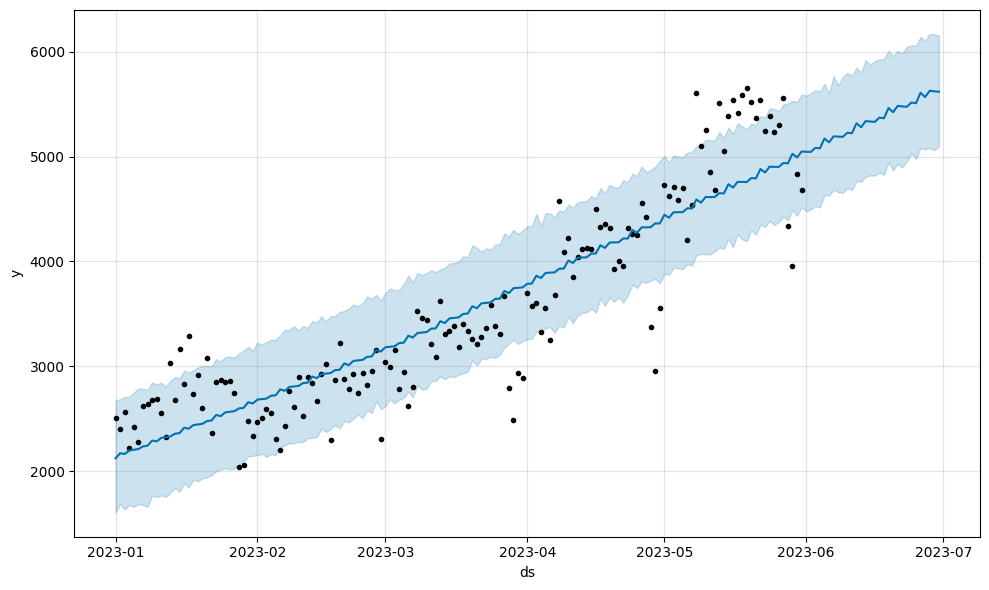

In [42]:
model_prophet.plot(forecast)
plt.show()

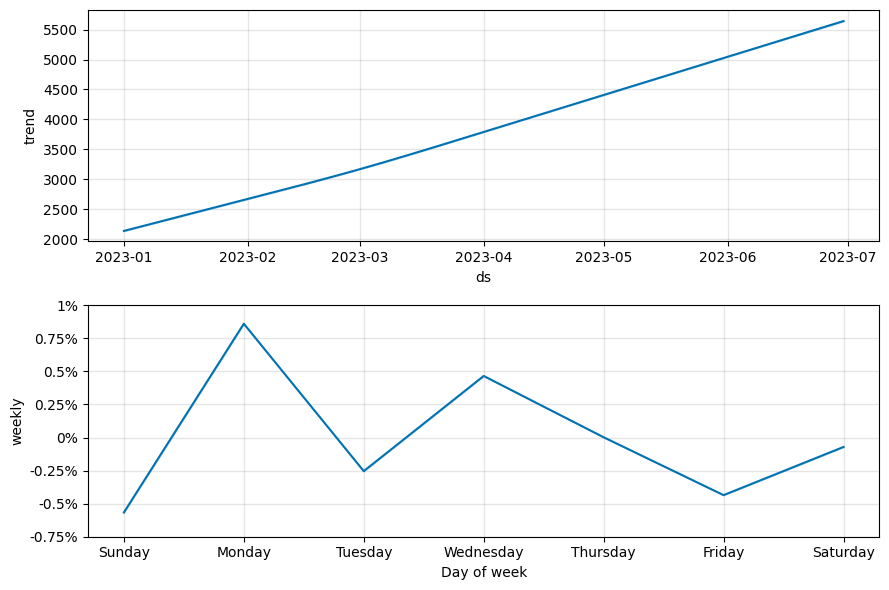

In [43]:
model_prophet.plot_components(forecast)
plt.show()

In [44]:
plot_plotly(model_prophet, forecast)

In [45]:
plot_components_plotly(model_prophet, forecast)

### Evaluation

In [47]:
prophet_pred = pd.DataFrame(forecast.yhat[-num_days:].values, index=forecast[-num_days:].ds.values)

prophet_rmse = round(np.sqrt(mean_squared_error(prophet_test.y, prophet_pred)),2)
print('Prophet RMSE:', prophet_rmse)

Prophet RMSE: 535.22


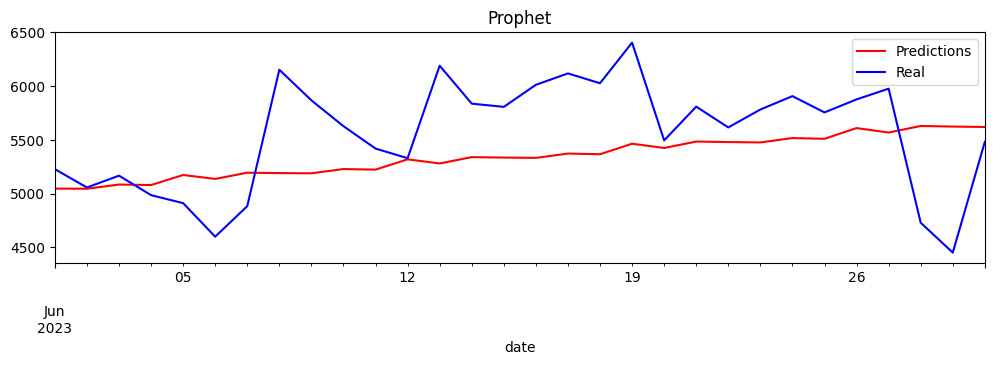

In [48]:
prophet_pred.plot(figsize=(12,3), color='red')
arima_test.sales.plot(color='blue')

plt.title('Prophet')
plt.legend(['Predictions','Real'])
plt.show()

## Results

In [49]:
predictions = pd.DataFrame(arima_pred.values, columns=['arima'], index=arima_test.index)
predictions['auto_arima'] = auto_pred.values
predictions['sarima'] = sarima_pred.values
predictions['prophet'] = prophet_pred.values
predictions['test'] = arima_test.sales
predictions.head(3)

,arima,auto_arima,sarima,prophet,test
date,,,,,
2023-06-01,5368.826943,4944.692369,4935.153189,5046.440918,5227.00
2023-06-02,5461.363296,4992.286965,4960.952782,5044.869493,5056.50
2023-06-03,5365.996282,4940.721061,4866.313319,5083.905365,5166.65


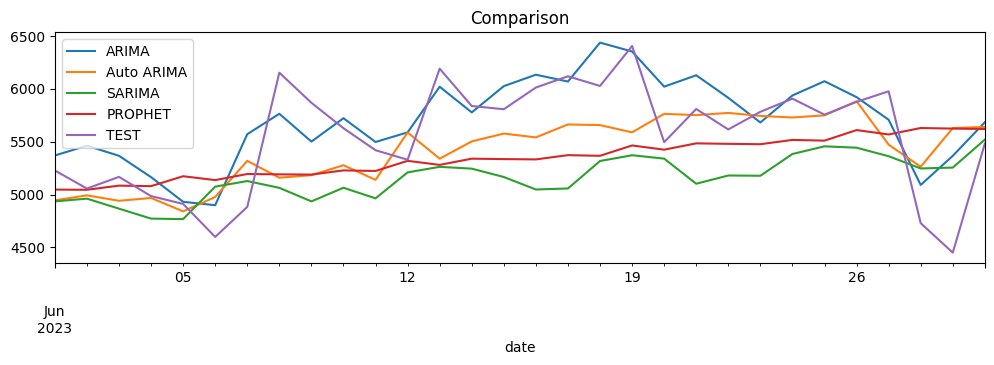

In [51]:
predictions.plot(figsize=(12,3))

plt.title('Comparison')
plt.legend(['ARIMA','Auto ARIMA','SARIMA','PROPHET','TEST'])
plt.show()

In [52]:
print('ARIMA RMSE:', round(arima_rmse,2))
print('Auto ARIMA RMSE:', round(auto_rmse,2))
print('SARIMA RMSE:', round(sarima_rmse,2))
print('PROPHET RMSE:', round(prophet_rmse,2))

ARIMA RMSE: 322.18
Auto ARIMA RMSE: 461.74
SARIMA RMSE: 613.57
PROPHET RMSE: 535.22
